<a href="https://colab.research.google.com/github/JorgeZarama/TFM-final-models/blob/main/Target_close_Test_de_Stock_Market_Analysis_Testing_Other_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importar Librería

In [1]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Attention, Layer, Input, Dropout, concatenate
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.callbacks import EarlyStopping
from sklearn import preprocessing
from tensorflow.keras.optimizers import Adam


Extracción de Datos


In [2]:
# 1. Extracción de datos
symbol = 'GOOGL'
df = yf.download(symbol, start='2004-08-19', end='2024-09-20', interval='1d')# oja que carga hasta el 19 de 09 de 2024
df.reset_index(inplace=True)
df['Date'] = pd.to_datetime(df['Date'])


[*********************100%***********************]  1 of 1 completed


In [3]:
display(df.describe(include='all'))
display(df.info())
print(df.head())
print(df.tail())

,Date,Open,High,Low,Close,Adj Close,Volume
count,5056,5056.000000,5056.000000,5056.000000,5056.000000,5056.000000,5.056000e+03
mean,2014-09-02 19:48:30.759493632,46.127009,46.610178,45.650578,46.140126,46.029264,1.168503e+08
min,2004-08-19 00:00:00,2.482232,2.546046,2.401401,2.502753,2.496571,9.312000e+06
25%,2009-08-25 18:00:00,13.136449,13.237800,12.983233,13.139139,13.106685,3.089300e+07
50%,2014-09-03 12:00:00,27.777500,27.962250,27.525249,27.730500,27.662004,5.880700e+07
75%,2019-09-11 06:00:00,61.214249,61.827874,60.733875,61.303500,61.152077,1.410198e+08
max,2024-09-19 00:00:00,190.309998,191.750000,189.029999,191.179993,190.926636,1.643023e+09
std,NaN,43.904672,44.387371,43.453038,43.927588,43.827804,1.475820e+08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5056 entries, 0 to 5055
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5056 non-null   datetime64[ns]
 1   Open       5056 non-null   float64       
 2   High       5056 non-null   float64       
 3   Low        5056 non-null   float64       
 4   Close      5056 non-null   float64       
 5   Adj Close  5056 non-null   float64       
 6   Volume     5056 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 276.6 KB


None

        Date      Open      High       Low     Close  Adj Close     Volume
0 2004-08-19  2.502503  2.604104  2.401401  2.511011   2.504808  893181924
1 2004-08-20  2.527778  2.729730  2.515015  2.710460   2.703765  456686856
2 2004-08-23  2.771522  2.839840  2.728979  2.737738   2.730975  365122512
3 2004-08-24  2.783784  2.792793  2.591842  2.624374   2.617892  304946748
4 2004-08-25  2.626627  2.702703  2.599600  2.652653   2.646101  183772044
           Date        Open        High         Low       Close   Adj Close  \
5051 2024-09-13  155.429993  158.380005  155.210007  157.460007  157.460007   
5052 2024-09-16  157.309998  158.250000  156.600006  158.059998  158.059998   
5053 2024-09-17  159.020004  160.550003  158.380005  159.320007  159.320007   
5054 2024-09-18  159.860001  160.500000  158.600006  159.809998  159.809998   
5055 2024-09-19  163.710007  163.789993  161.339996  162.139999  162.139999   

        Volume  
5051  29591200  
5052  18379800  
5053  20715600  
5054  2

Revisar la Data

Gráficamos el valor de la acción (precio de cierre)

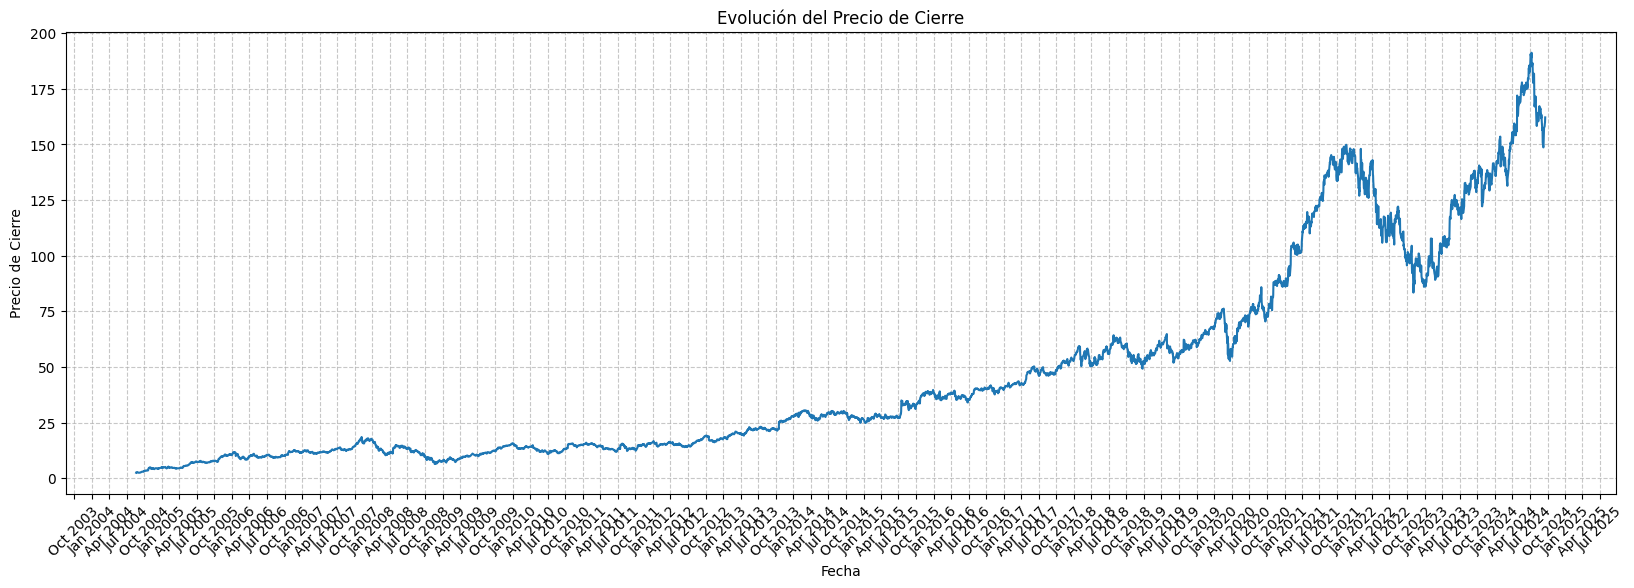

In [4]:
# Filtrar los datos por el rango de fechas

#df_filtrado = df[(df['Date'] >= '2004-08-20') & (df['Date'] <= '2024-07-31')]

# Crear el gráfico de línea
plt.figure(figsize=(20, 6))
sns.lineplot(x='Date', y='Close', data=df)

# Personalizar el eje x para mostrar meses y años
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

# Agregar título y etiquetas a los ejes
plt.title('Evolución del Precio de Cierre')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')

# Agregar una cuadrícula para facilitar la lectura
plt.grid(True, linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.show()

Seleccionar las características y la variable objetivo

In [4]:
##Escalado de Datos
close_prices = df['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
close_prices_scaled = scaler.fit_transform(close_prices)


In [5]:
#Función para crear las secuencias temporales

def create_lstm_data(data, time_steps):
  x, y = [], []
  for i in range(len(data) - time_steps): #removed extra indent
    x.append(data[i:(i + time_steps), 0]) #indented correctly
    y.append(data[i + time_steps, 0]) #indented correctly
  return np.array(x), np.array(y)

##para time step = 2 y np [[1],[2],[3],[4]]
##[1,2][3]  and [2,3][4]

## Modelo híbrido CNN-LSTM-Transformer

In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, MultiHeadAttention, LayerNormalization, Add

# Crear las secuencias de entrenamiento
time_steps = 128
x_total, y_total = create_lstm_data(close_prices_scaled, time_steps)

# Dividir en conjunto de entrenamiento y prueba
dis = int(len(x_total) * 0.95)
x_train, x_test = x_total[:dis], x_total[dis:]
y_train, y_test = y_total[:dis], y_total[dis:]

# Redimensionar los datos para que sean compatibles con Conv1D y LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Definir el input
inputs = Input(shape=(x_train.shape[1], 1))

# Capa convolucional
conv_output = Conv1D(filters=32, kernel_size=3, activation='relu')(inputs)
conv_output = MaxPooling1D(pool_size=2)(conv_output)

# Capas LSTM
lstm_output = LSTM(units=50, return_sequences=True)(conv_output)  # Devolver secuencias completas
lstm_output = LSTM(units=50, return_sequences=True)(lstm_output)  # Mantener secuencias para la atención

# Bloque de Transformer
# Usar secuencias completas como query, key y value
attention_output = MultiHeadAttention(num_heads=4, key_dim=64)(lstm_output, lstm_output)
attention_output = Add()([lstm_output, attention_output])  # Residual connection
attention_output = LayerNormalization()(attention_output)

# Capa de salida
outputs = Dense(units=1)(attention_output[:, -1, :])  # Seleccionar solo el último paso de la secuencia

# Definir el modelo
model = Model(inputs=inputs, outputs=outputs)

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Entrenar el modelo
history = model.fit(x_train, y_train, epochs=30, batch_size=32, validation_data=(x_test, y_test))


Epoch 1/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 30s 143ms/step - loss: 0.1695 - mean_absolute_error: 0.2418 - val_loss: 0.0071 - val_mean_absolute_error: 0.0742
Epoch 2/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - loss: 3.8936e-04 - mean_absolute_error: 0.0133 - val_loss: 0.0023 - val_mean_absolute_error: 0.0387
Epoch 3/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - loss: 2.0485e-04 - mean_absolute_error: 0.0093 - val_loss: 0.0045 - val_mean_absolute_error: 0.0577
Epoch 4/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 22s 144ms/step - loss: 2.2955e-04 - mean_absolute_error: 0.0107 - val_loss: 0.0025 - val_mean_absolute_error: 0.0413
Epoch 5/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 40s 139ms/step - loss: 2.3710e-04 - mean_absolute_error: 0.0109 - val_loss: 0.0024 - val_mean_absolute_error: 0.0412
Epoch 6/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 19s 132ms/step - loss: 2.3149e-04 - mean_absolute_error: 0.0110 - val_loss: 0.0026 - val_mean_absolute_error: 0.0434
Epoch 7/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - loss:

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 5.6052e-04 - mean_absolute_error: 0.0179
perdidas de test [0.0005809118156321347, 0.019206209108233452]


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
Test Loss (MSE): [0.0005809118156321347, 0.019206209108233452]
Mean Absolute Error (MAE): 3.623775343180668
Mean Squared Error (MSE): 20.67994394118714
Root Mean Squared Error (RMSE): 4.547520636697226
R-squared (R²): 0.9314075545527111


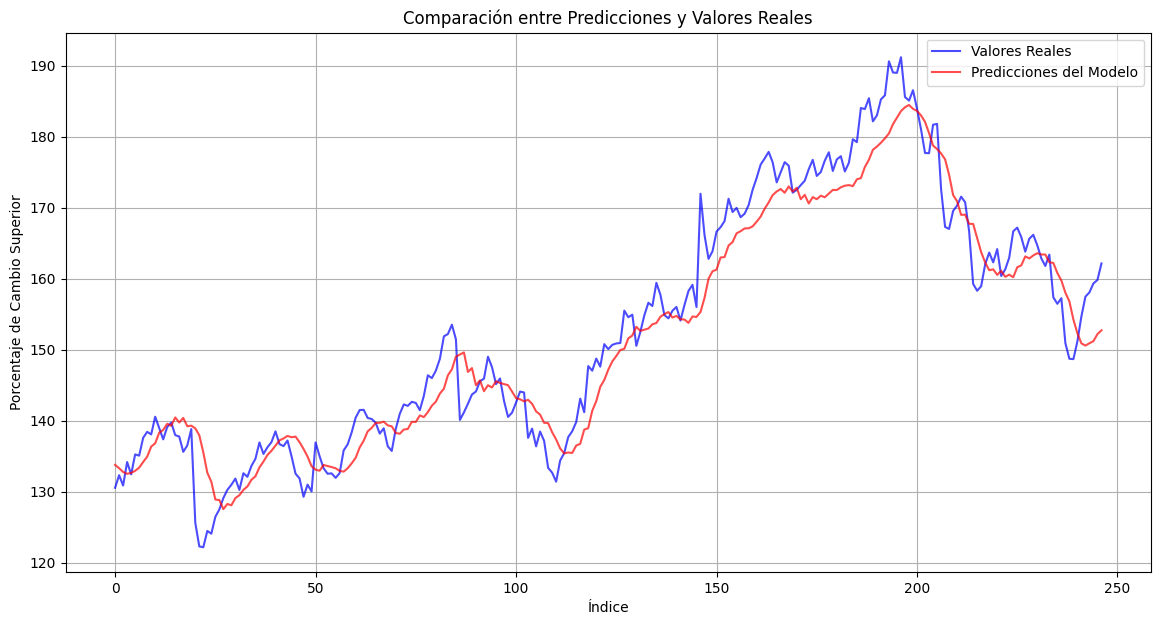

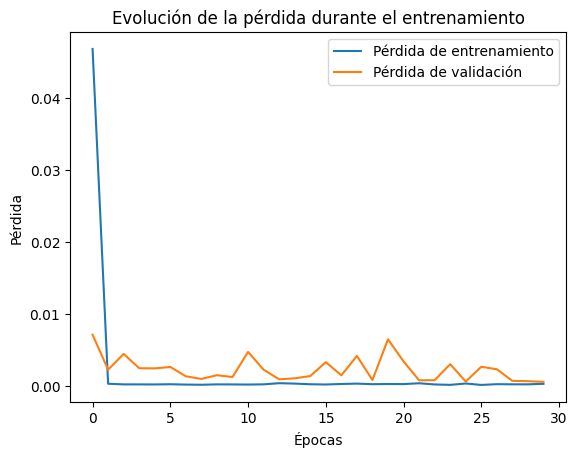

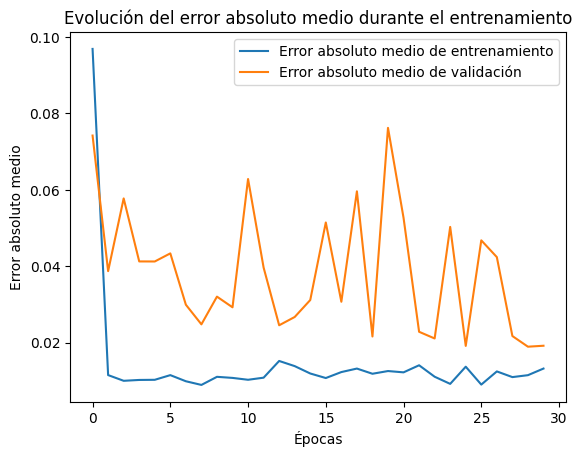

In [22]:
# Evaluar el modelo en el conjunto de prueba
test_loss = model.evaluate(x_test, y_test)
print("perdidas de test", test_loss)
# Predicción
predictions = model.predict(x_test)

# Desescalar las predicciones
predictions = scaler.inverse_transform(predictions)

#Reshape y_test to be a 2D array before inverse_transform
y_test = y_test.reshape(-1, 1)

y_test = scaler.inverse_transform(y_test)

# Calcular métricas adicionales
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

# Mostrar las métricas
print(f"Test Loss (MSE): {test_loss}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

# Crear el gráfico
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Valores Reales', color='blue', alpha=0.7)
plt.plot(predictions, label='Predicciones del Modelo', color='red', alpha=0.7)
plt.xlabel('Índice')
plt.ylabel('Porcentaje de Cambio Superior')
plt.title('Comparación entre Predicciones y Valores Reales')
plt.legend()
plt.grid(True)
plt.show()

# Graficar la pérdida (loss)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Evolución de la pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Graficar el error absoluto medio (mean_absolute_error)
plt.plot(history.history['mean_absolute_error'], label='Error absoluto medio de entrenamiento')
plt.plot(history.history['val_mean_absolute_error'], label='Error absoluto medio de validación')
plt.title('Evolución del error absoluto medio durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Error absoluto medio')
plt.legend()
plt.show()

## Redes Neuronales Recurrentes Bidireccionales (Bi-LSTM)

In [8]:
from tensorflow.keras.layers import Bidirectional

time_steps = 128
x_total, y_total = create_lstm_data(close_prices_scaled, time_steps)

dis = int(len(x_total) * 0.95)
display(dis)
x_train, x_test = x_total[:dis], x_total[dis:]
y_train, y_test = y_total[:dis], y_total[dis:]

x = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
model = Sequential()
model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(x_train.shape[1], 1)))
model.add(Bidirectional(LSTM(50)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
history = model.fit(x_train, y_train, epochs=30, batch_size=32, validation_data=(x_test, y_test))

4681

Epoch 1/30
147/147 [==============================] - 21s 106ms/step - loss: 0.0020 - mean_absolute_error: 0.0200 - val_loss: 0.0011 - val_mean_absolute_error: 0.0281
Epoch 2/30
147/147 [==============================] - 15s 105ms/step - loss: 1.3838e-04 - mean_absolute_error: 0.0069 - val_loss: 7.8964e-04 - val_mean_absolute_error: 0.0227
Epoch 3/30
147/147 [==============================] - 16s 106ms/step - loss: 1.1808e-04 - mean_absolute_error: 0.0065 - val_loss: 9.1938e-04 - val_mean_absolute_error: 0.0254
Epoch 4/30
147/147 [==============================] - 15s 102ms/step - loss: 1.0917e-04 - mean_absolute_error: 0.0063 - val_loss: 0.0014 - val_mean_absolute_error: 0.0324
Epoch 5/30
147/147 [==============================] - 14s 92ms/step - loss: 1.1402e-04 - mean_absolute_error: 0.0064 - val_loss: 6.3077e-04 - val_mean_absolute_error: 0.0187
Epoch 6/30
147/147 [==============================] - 15s 100ms/step - loss: 9.0512e-05 - mean_absolute_error: 0.0057 - val_loss: 7.2060e-

8/8 [==============================] - 0s 37ms/step - loss: 3.0232e-04 - mean_absolute_error: 0.0136
perdidas de test [0.00030231510754674673, 0.013605624437332153]
8/8 [==============================] - 2s 35ms/step
Test Loss (MSE): [0.00030231510754674673, 0.013605624437332153]
Mean Absolute Error (MAE): 2.567072694600835
Mean Squared Error (MSE): 10.762150628560573
Root Mean Squared Error (RMSE): 3.280571692336653
R-squared (R²): 0.9643034704550234


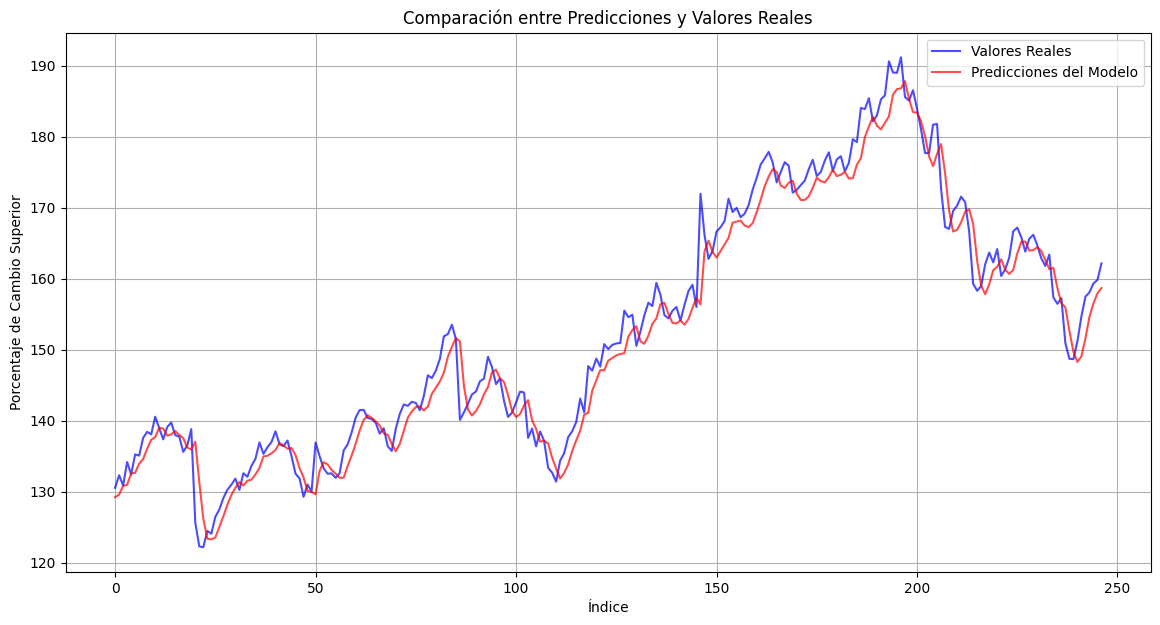

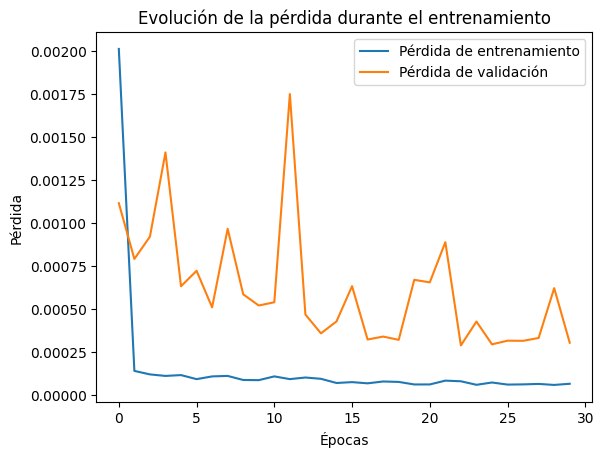

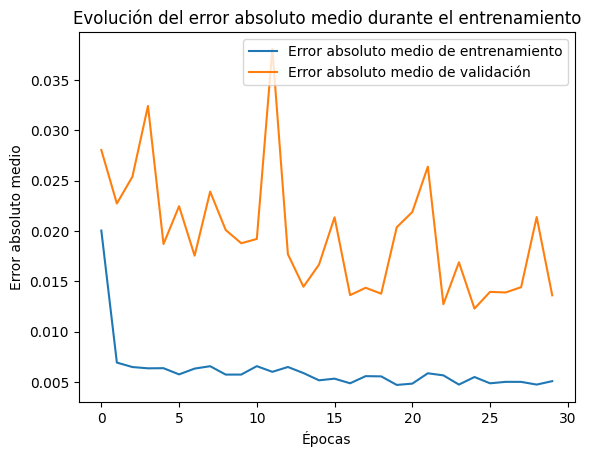

In [9]:
# Evaluar el modelo en el conjunto de prueba
test_loss = model.evaluate(x_test, y_test)
print("perdidas de test", test_loss)
# Predicción
predictions = model.predict(x_test)

# Desescalar las predicciones
predictions = scaler.inverse_transform(predictions)

#Reshape y_test to be a 2D array before inverse_transform
y_test = y_test.reshape(-1, 1)

y_test = scaler.inverse_transform(y_test)

# Calcular métricas adicionales
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

# Mostrar las métricas
print(f"Test Loss (MSE): {test_loss}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

# Crear el gráfico
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Valores Reales', color='blue', alpha=0.7)
plt.plot(predictions, label='Predicciones del Modelo', color='red', alpha=0.7)
plt.xlabel('Índice')
plt.ylabel('Porcentaje de Cambio Superior')
plt.title('Comparación entre Predicciones y Valores Reales')
plt.legend()
plt.grid(True)
plt.show()

# Graficar la pérdida (loss)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Evolución de la pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Graficar el error absoluto medio (mean_absolute_error)
plt.plot(history.history['mean_absolute_error'], label='Error absoluto medio de entrenamiento')
plt.plot(history.history['val_mean_absolute_error'], label='Error absoluto medio de validación')
plt.title('Evolución del error absoluto medio durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Error absoluto medio')
plt.legend()
plt.show()

## GRU (Gated Recurrent Units)

In [9]:
from tensorflow.keras.layers import GRU
time_steps = 128
x_total, y_total = create_lstm_data(close_prices_scaled, time_steps)

dis = int(len(x_total) * 0.95)
display(dis)
x_train, x_test = x_total[:dis], x_total[dis:]
y_train, y_test = y_total[:dis], y_total[dis:]

x = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(GRU(units=50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
history = model.fit(x_train, y_train, epochs=30, batch_size=32, validation_data=(x_test, y_test))


4681

Epoch 1/30
147/147 [==============================] - 16s 91ms/step - loss: 0.0035 - mean_absolute_error: 0.0227 - val_loss: 5.2140e-04 - val_mean_absolute_error: 0.0186
Epoch 2/30
147/147 [==============================] - 12s 85ms/step - loss: 6.9339e-05 - mean_absolute_error: 0.0048 - val_loss: 4.1106e-04 - val_mean_absolute_error: 0.0153
Epoch 3/30
147/147 [==============================] - 13s 85ms/step - loss: 6.8997e-05 - mean_absolute_error: 0.0050 - val_loss: 5.7477e-04 - val_mean_absolute_error: 0.0202
Epoch 4/30
147/147 [==============================] - 12s 79ms/step - loss: 6.0407e-05 - mean_absolute_error: 0.0046 - val_loss: 3.5439e-04 - val_mean_absolute_error: 0.0147
Epoch 5/30
147/147 [==============================] - 13s 86ms/step - loss: 6.0586e-05 - mean_absolute_error: 0.0047 - val_loss: 4.9427e-04 - val_mean_absolute_error: 0.0186
Epoch 6/30
147/147 [==============================] - 13s 86ms/step - loss: 5.7572e-05 - mean_absolute_error: 0.0047 - val_loss: 2.959

8/8 [==============================] - 0s 23ms/step - loss: 2.7035e-04 - mean_absolute_error: 0.0127
perdidas de test [0.00027035296079702675, 0.012714135460555553]
8/8 [==============================] - 1s 21ms/step
Test Loss (MSE): [0.00027035296079702675, 0.012714135460555553]
Mean Absolute Error (MAE): 2.398869688211665
Mean Squared Error (MSE): 9.624333431860354
Root Mean Squared Error (RMSE): 3.102310982454911
R-squared (R²): 0.9680774489636501


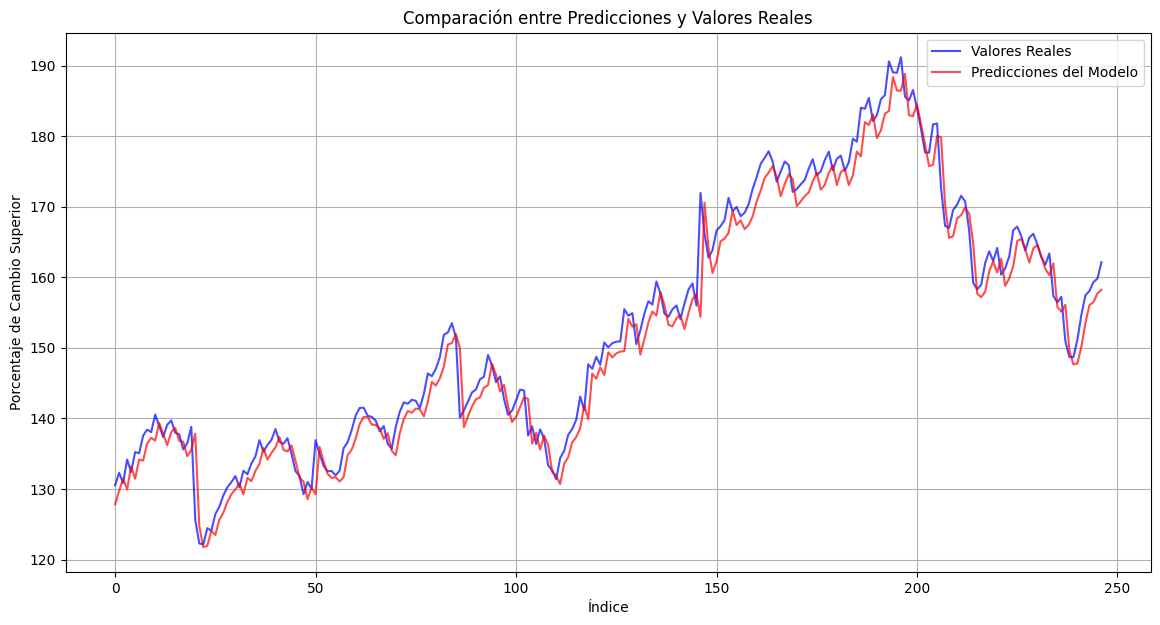

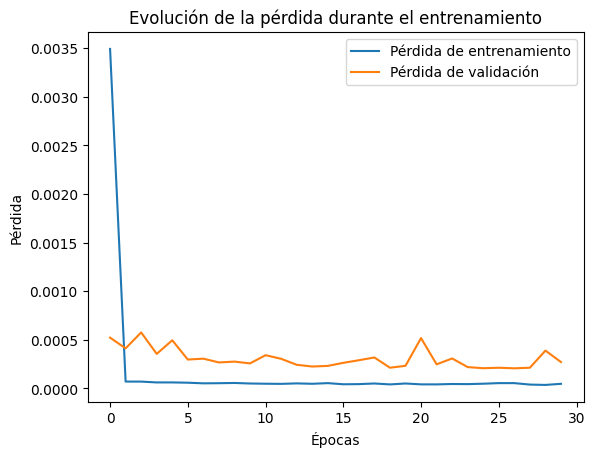

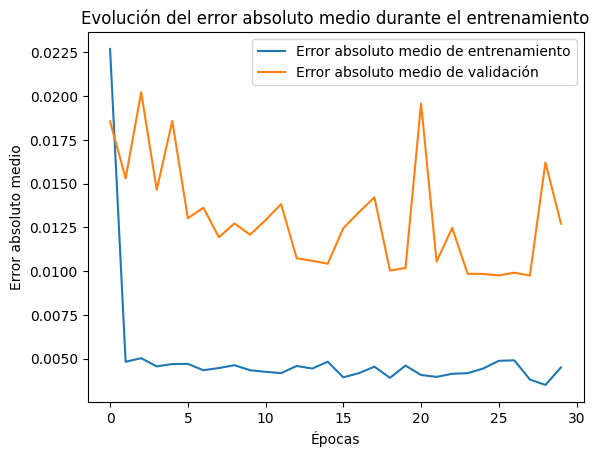

In [10]:
# Evaluar el modelo en el conjunto de prueba
test_loss = model.evaluate(x_test, y_test)
print("perdidas de test", test_loss)
# Predicción
predictions = model.predict(x_test)

# Desescalar las predicciones
predictions = scaler.inverse_transform(predictions)

#Reshape y_test to be a 2D array before inverse_transform
y_test = y_test.reshape(-1, 1)

y_test = scaler.inverse_transform(y_test)

# Calcular métricas adicionales
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

# Mostrar las métricas
print(f"Test Loss (MSE): {test_loss}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

# Crear el gráfico
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Valores Reales', color='blue', alpha=0.7)
plt.plot(predictions, label='Predicciones del Modelo', color='red', alpha=0.7)
plt.xlabel('Índice')
plt.ylabel('Porcentaje de Cambio Superior')
plt.title('Comparación entre Predicciones y Valores Reales')
plt.legend()
plt.grid(True)
plt.show()

# Graficar la pérdida (loss)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Evolución de la pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Graficar el error absoluto medio (mean_absolute_error)
plt.plot(history.history['mean_absolute_error'], label='Error absoluto medio de entrenamiento')
plt.plot(history.history['val_mean_absolute_error'], label='Error absoluto medio de validación')
plt.title('Evolución del error absoluto medio durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Error absoluto medio')
plt.legend()
plt.show()

In [11]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128, 50)           7950      
                                                                 
 gru_1 (GRU)                 (None, 50)                15300     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 23301 (91.02 KB)
Trainable params: 23301 (91.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
